<a href="https://colab.research.google.com/github/Jenniferli6/XAI_Explainable_Techniques_II/blob/main/XAI_Explainable_Techniques_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI Explainable Techniques II
#### Jennifer Li

In this project, I used the **Financial-Risk-Assessment** dataset from [OpenML](https://www.openml.org/d/45041), which contains demographic, financial, and behavioral information on 15,000 individuals with a three-level credit risk rating (`0` = low risk, `1` = medium risk, `2` = high risk).

I trained a Random Forest model and a Gradient Boosting model to **predict borrowers’ risk ratings**. Then, I applied **PDP, ICE, and ALE plots** to analyze how the top three features influenced the probability of being classified as medium risk.

*Note: ChatGPT5 was used to help debug the code and polish the interpretation wording.*

In [28]:
# !pip install alibi

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.inspection import PartialDependenceDisplay, partial_dependence
from alibi.explainers import ALE

import warnings
warnings.filterwarnings('ignore')

In [30]:
# Load Data
from sklearn.datasets import fetch_openml
data = fetch_openml(name='Financial-Risk-Assessment', version=1, as_frame=True)
df = data.frame
df.sample(5)

,age,gender,education_level,marital_status,income,credit_score,loan_amount,loan_purpose,employment_status,years_at_current_job,payment_history,debt-to-income_ratio,assets_value,number_of_dependents,city,state,country,previous_defaults,marital_status_change,risk_rating
12347,26,Female,'Bachelor's',Divorced,41773.0,781.0,22866.0,Personal,Employed,3,Good,0.339122,186155.0,NaN,Watkinsfort,NC,Slovenia,2.0,2,1
4430,60,Female,PhD,Single,101551.0,770.0,14319.0,Business,Unemployed,10,Poor,0.530276,NaN,1.0,Joycemouth,PR,Guatemala,NaN,2,0
3761,35,Male,'Bachelor's',Divorced,107954.0,NaN,33478.0,Home,Employed,1,Good,0.516323,267755.0,1.0,'West David',MT,Myanmar,NaN,2,1
12907,68,Non-binary,'Master's',Divorced,NaN,650.0,NaN,Auto,Unemployed,3,Poor,0.379834,209096.0,1.0,Wongburgh,SD,Bahamas,4.0,2,2
12302,66,Non-binary,'Master's',Single,NaN,742.0,41782.0,Home,Unemployed,0,Excellent,0.139067,99837.0,NaN,Susanberg,PW,Reunion,4.0,1,0


## 1. Exploratory Data Analysis

In [31]:
print('Data Dimension:\n', df.shape)
print()
print('Data Types:\n', df.dtypes)

Data Dimension:
 (15000, 20)

Data Types:
 age                         int64
gender                     object
education_level            object
marital_status             object
income                    float64
credit_score              float64
loan_amount               float64
loan_purpose               object
employment_status          object
years_at_current_job        int64
payment_history            object
debt-to-income_ratio      float64
assets_value              float64
number_of_dependents      float64
city                       object
state                      object
country                    object
previous_defaults         float64
marital_status_change       int64
risk_rating              category
dtype: object


In [32]:
print('Missing Values:\n', df.isnull().sum())

Missing Values:
 age                         0
gender                      0
education_level             0
marital_status              0
income                   2250
credit_score             2250
loan_amount              2250
loan_purpose                0
employment_status           0
years_at_current_job        0
payment_history             0
debt-to-income_ratio        0
assets_value             2250
number_of_dependents     2250
city                        0
state                       0
country                     0
previous_defaults        2250
marital_status_change       0
risk_rating                 0
dtype: int64


In [33]:
df = df.dropna()
print('Data Dimension After Dropping:\n', df.shape)

print('Missing Values:\n', df.isnull().sum())

Data Dimension After Dropping:
 (5716, 20)
Missing Values:
 age                      0
gender                   0
education_level          0
marital_status           0
income                   0
credit_score             0
loan_amount              0
loan_purpose             0
employment_status        0
years_at_current_job     0
payment_history          0
debt-to-income_ratio     0
assets_value             0
number_of_dependents     0
city                     0
state                    0
country                  0
previous_defaults        0
marital_status_change    0
risk_rating              0
dtype: int64


In [34]:
print('Duplicate Values:\n', df.duplicated().sum())

Duplicate Values:
 0


In [35]:
df.nunique()

,0
age,52
gender,3
education_level,4
marital_status,4
income,5547
credit_score,200
loan_amount,5350
loan_purpose,4
employment_status,3
years_at_current_job,20


In [36]:
# I want to check variables whose number of unique values is less than 6

col_uni_less_6 = [col for col in df.columns if df[col].nunique() < 6]
for col in col_uni_less_6:
  print(f'{col}: ({df[col].dtype}): {df[col].unique()}')



gender: (object): ['Male' 'Non-binary' 'Female']
education_level: (object): ['PhD' "'Master's'" "'Bachelor's'" "'High School'"]
marital_status: (object): ['Divorced' 'Single' 'Married' 'Widowed']
loan_purpose: (object): ['Business' 'Home' 'Personal' 'Auto']
employment_status: (object): ['Unemployed' 'Employed' 'Self-employed']
payment_history: (object): ['Poor' 'Fair' 'Excellent' 'Good']
number_of_dependents: (float64): [0. 3. 2. 4. 1.]
previous_defaults: (float64): [2. 3. 4. 0. 1.]
marital_status_change: (int64): [2 0 1]
risk_rating: (category): ['0', '1', '2']
Categories (3, object): ['0', '1', '2']


In [37]:
# I want to check variables whose number of unique values is no less than 6

col_uni_more_6 = [col for col in df.columns if df[col].nunique() >= 6]
for col in col_uni_more_6:
  print(f'{col}: ({df[col].dtype})')


age: (int64)
income: (float64)
credit_score: (float64)
loan_amount: (float64)
years_at_current_job: (int64)
debt-to-income_ratio: (float64)
assets_value: (float64)
city: (object)
state: (object)
country: (object)


In [38]:
df.dtypes

,0
age,int64
gender,object
education_level,object
marital_status,object
income,float64
credit_score,float64
loan_amount,float64
loan_purpose,object
employment_status,object
years_at_current_job,int64


In [39]:
num_col = df.select_dtypes(include=['int64', 'float64']).columns
cat_col = df.select_dtypes(include=['object']).columns
print(num_col)
print(cat_col)

Index(['age', 'income', 'credit_score', 'loan_amount', 'years_at_current_job',
       'debt-to-income_ratio', 'assets_value', 'number_of_dependents',
       'previous_defaults', 'marital_status_change'],
      dtype='object')
Index(['gender', 'education_level', 'marital_status', 'loan_purpose',
       'employment_status', 'payment_history', 'city', 'state', 'country'],
      dtype='object')


In [40]:
# Target variable distribution
df['risk_rating'].value_counts()

,count
risk_rating,
0,3424
1,1729
2,563


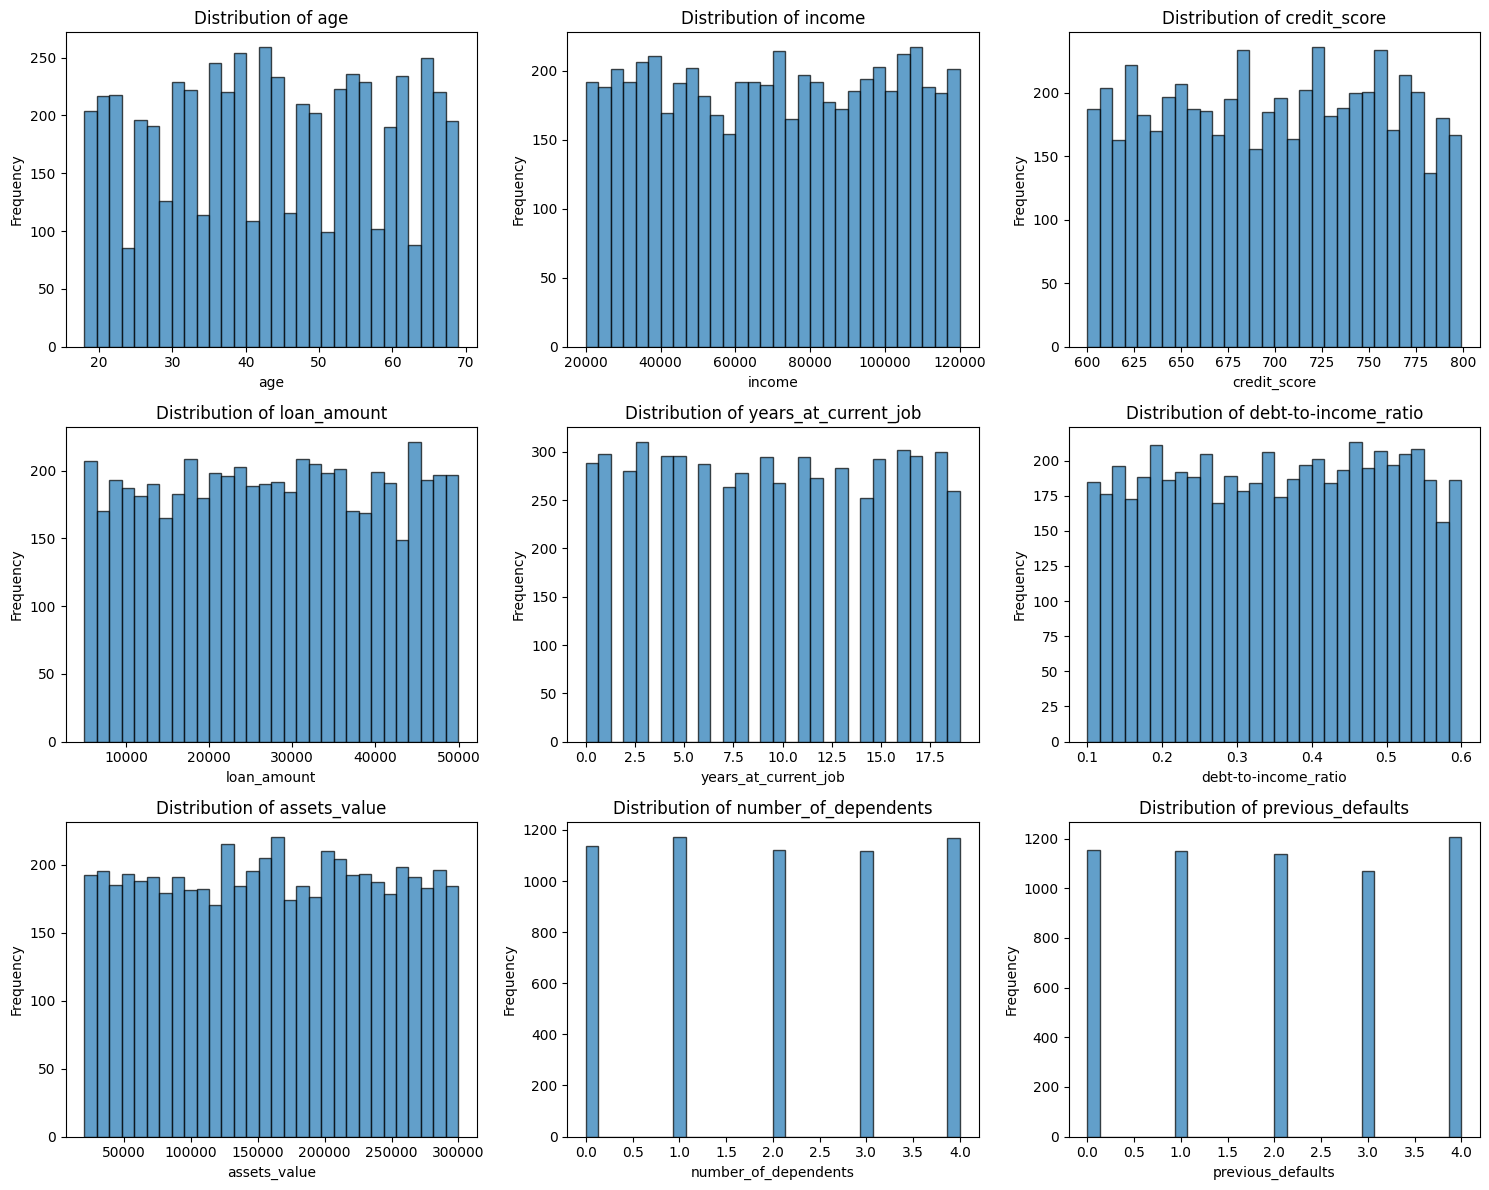

In [41]:
# Numerical features distribution

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for i, feature in enumerate(num_col):
    if i < len(axes):
        axes[i].hist(df[feature], bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {feature}')
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

I noticed that most numeric features are fairly uniform. For example, age, income, credit score, loan amount, and assets value are spread across their ranges without sharp peaks. Debt-to-income ratio looks relatively balanced within its 0.1–0.6 range. Therefore, the borrower profiles do not have heavy skew in the continuous variables.

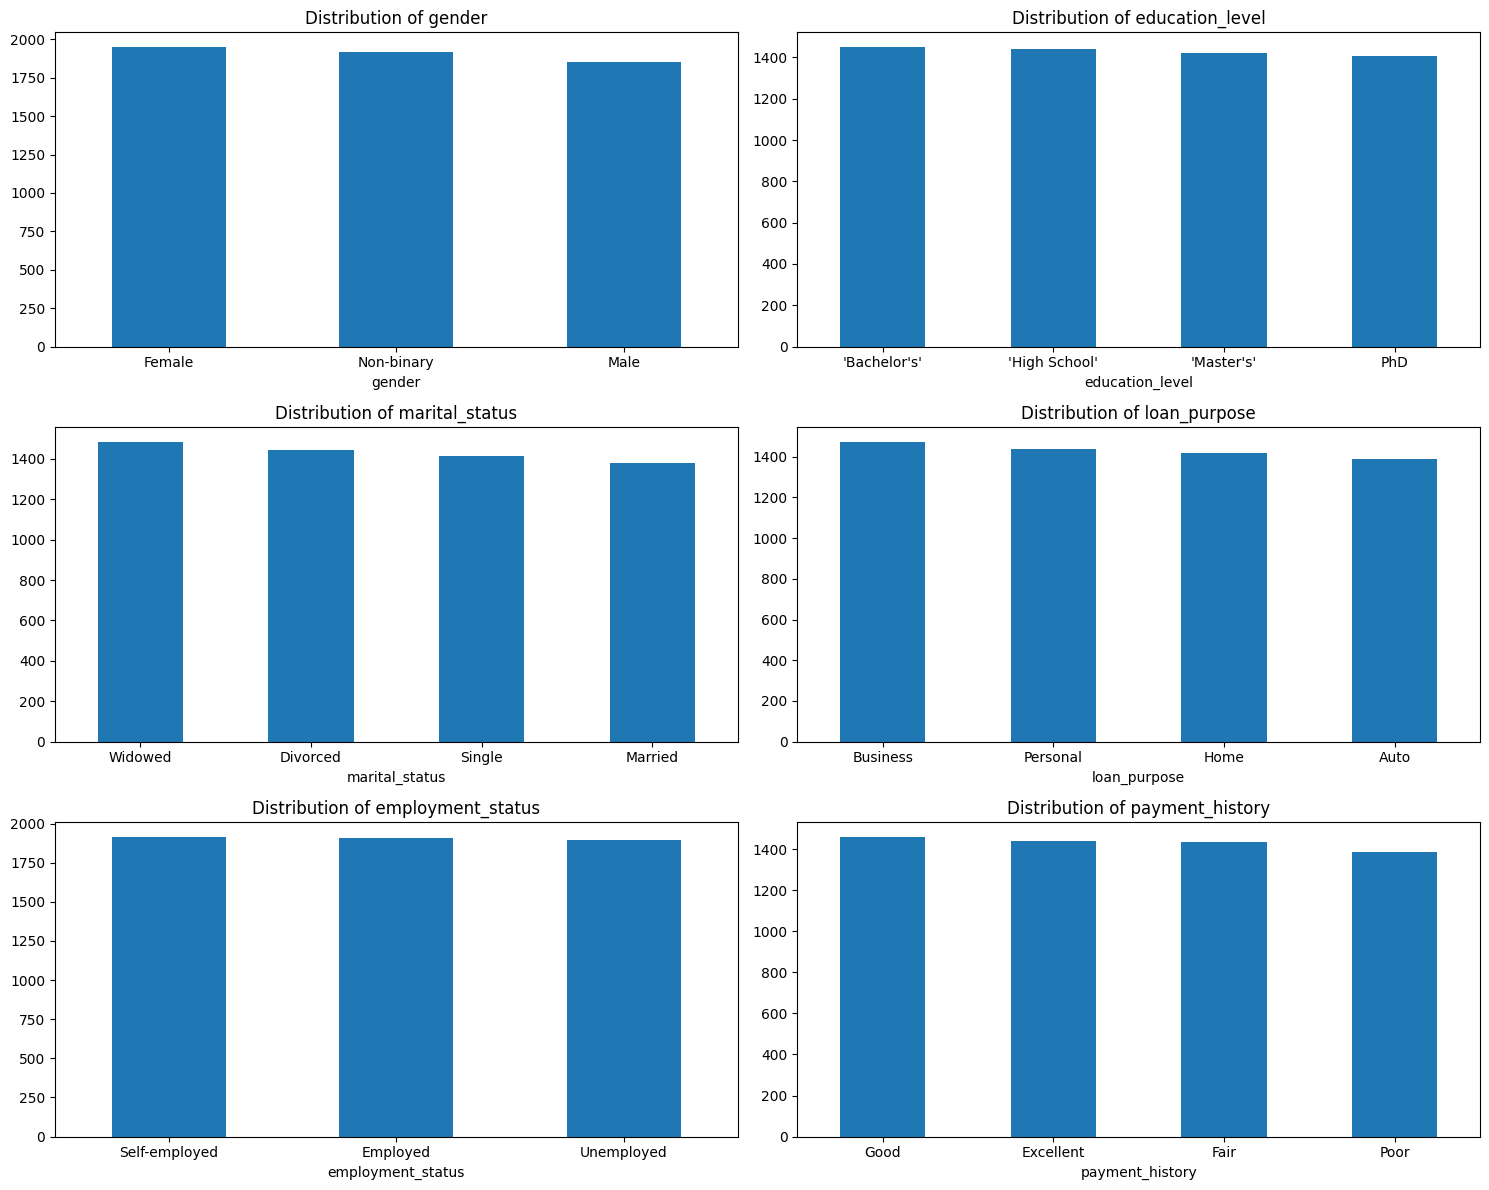

In [42]:
# Categorical features distribution

fig, axes = plt.subplots(3, 2, figsize=(15, 12))
cat_col_interested = ['gender', 'education_level', 'marital_status', 'loan_purpose', 'employment_status', 'payment_history']

for i, feature in enumerate(cat_col_interested):
    row, col = i // 2, i % 2
    df[feature].value_counts().plot(kind='bar', ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of {feature}')
    axes[row, col].tick_params(axis='x', rotation = 0)

plt.tight_layout()
plt.show()

The bar charts show that the categorical features are also quite balanced. For instance, gender is almost evenly split among male, female, and non-binary categories. The payment history variable shows a fairly uniform distribution across Poor, Fair, Good, and Excellent. This means that there is no single category dominates, reducing the risk of strong class imbalance in these predictors.

## 2. Correlation Analysis

In [43]:
df_encoded = df.copy()

label_encoders = {}
for col in cat_col:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    label_encoders[col] = le


# Convert risk_rating to numeric
df_encoded['risk_rating'] = df_encoded['risk_rating'].astype(int)

# Calculate correlation matrix
correlation_matrix = df_encoded.corr()


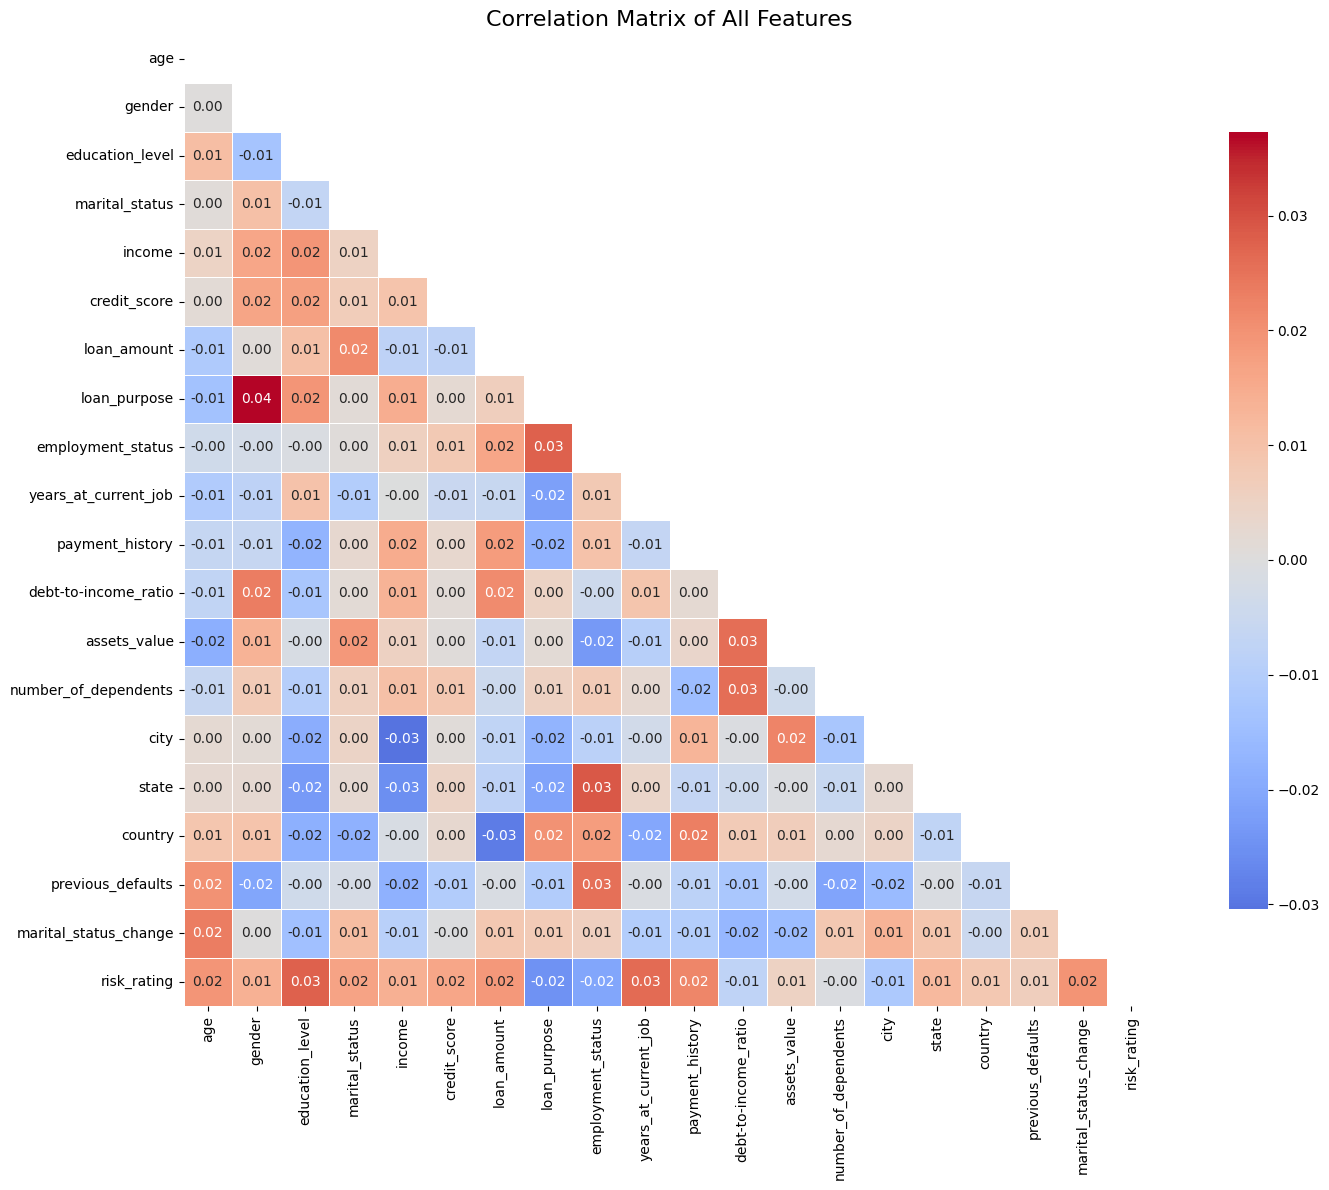

In [44]:
# Plot correlation heatmap
plt.figure(figsize=(16, 12))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8}, fmt='.2f')
plt.title('Correlation Matrix of All Features', fontsize=16)
plt.tight_layout()
plt.show()

When I examined the correlation matrix, I found that almost all feature correlations were very weak, close to zero. The largest values were around ±0.03, which means there are no strong linear relationships either between predictors themselves or between predictors and the target variable risk_rating.

For example, education level and years at current job had small positive correlations with risk rating, while loan purpose and empoyment status showed small negative ones.



## 3. Modeling

In [45]:
df.dtypes

,0
age,int64
gender,object
education_level,object
marital_status,object
income,float64
credit_score,float64
loan_amount,float64
loan_purpose,object
employment_status,object
years_at_current_job,int64


In [46]:
# Prepare features for modeling
features = df.drop(['risk_rating', 'city', 'state', 'country'], axis=1) # remove target variable and categorical variable whose number of unique values exceeds 6, otherwise we will have too many dummy variables when encoding them
target = df['risk_rating'].astype(int)

cat_feature = features.select_dtypes(include=['object']).columns
num_feature = features.select_dtypes(include=['int64', 'float64']).columns
print(cat_feature)
print(num_feature)


Index(['gender', 'education_level', 'marital_status', 'loan_purpose',
       'employment_status', 'payment_history'],
      dtype='object')
Index(['age', 'income', 'credit_score', 'loan_amount', 'years_at_current_job',
       'debt-to-income_ratio', 'assets_value', 'number_of_dependents',
       'previous_defaults', 'marital_status_change'],
      dtype='object')


In [47]:
features_encoded = features.copy()

for col in cat_feature:
    le = LabelEncoder()
    features_encoded[col] = le.fit_transform(features_encoded[col])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    features_encoded, target, test_size=0.2, random_state=42, stratify=target
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

Training set size: (4572, 16)
Test set size: (1144, 16)


In [48]:
# I want to try 2 different models

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42, max_depth=6)
}

model_results = {}
trained_models = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    trained_models[name] = (model, X_test)

    accuracy = accuracy_score(y_test, y_pred)
    model_results[name] = accuracy

    print(f"{name} Accuracy: {accuracy:.4f}")
    print(f"{name} Classification Report:")
    print(classification_report(y_test, y_pred))


Training Random Forest...
Random Forest Accuracy: 0.5979
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.60      1.00      0.75       685
           1       0.25      0.00      0.01       346
           2       0.00      0.00      0.00       113

    accuracy                           0.60      1144
   macro avg       0.28      0.33      0.25      1144
weighted avg       0.43      0.60      0.45      1144


Training Gradient Boosting...
Gradient Boosting Accuracy: 0.5594
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.90      0.71       685
           1       0.23      0.06      0.10       346
           2       0.17      0.01      0.02       113

    accuracy                           0.56      1144
   macro avg       0.33      0.32      0.28      1144
weighted avg       0.44      0.56      0.46      1144



As we can see, the Random Forest performed slightly better than Gradient Boosting. The Random Forest reached about 60% accuracy, compared with 56% for Gradient Boosting.

Looking at the classification reports, I noticed that both models performed well in predicting the low-risk class (0), with high recall (1.00 for Random Forest, 0.90 for Gradient Boosting). However, they struggled significantly with the medium-risk (1) and high-risk (2) classes, where recall was close to zero and the F1-scores were very low. This shows that the models might be biased toward predicting the majority class (low risk).

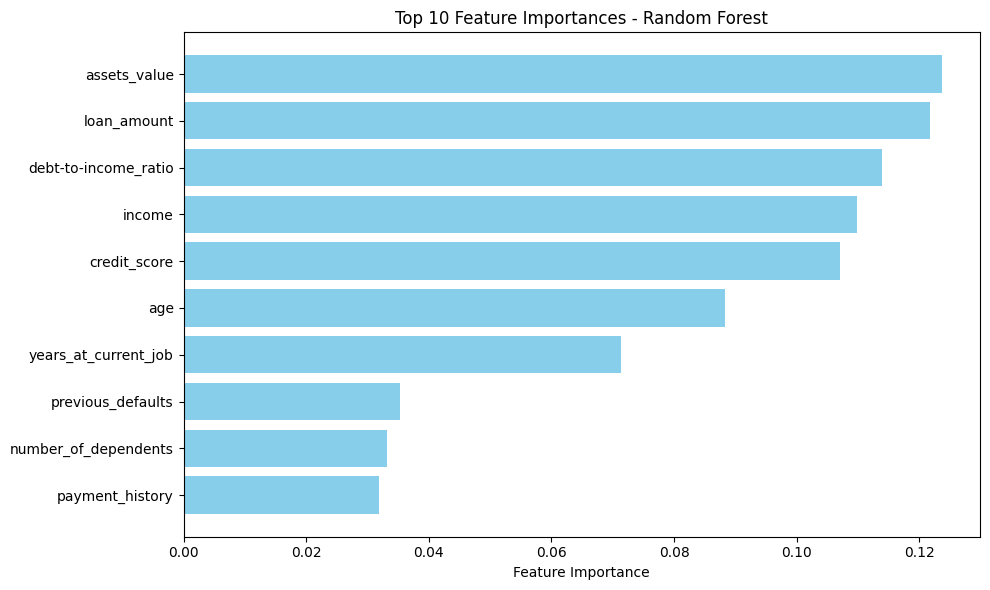

In [49]:
# Feature importance
rf_model = models['Random Forest']
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
top_10 = feature_importance.head(10)
plt.barh(top_10['feature'], top_10['importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Top 10 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In Random Forest Model, 3 features (i.e. assets value, loan amount, debt-to-income ratio) stood out well above the others. This makes sense because they directly reflect financial strength, borrowing behavior, and repayment capacity. Features like years at current job, previous defaults, number of dependents, and payment history contributed, but at a much smaller scale.

## 4. PDP, ICE, ALE Plots

In [50]:
# Select top 3 features for interpretation
top_features = feature_importance.head(3)['feature'].tolist()
top_features

['assets_value', 'loan_amount', 'debt-to-income_ratio']

### 4.1 PDP Plot

The Partial Dependence Plot (PDP) shows the average effect of a feature on the model’s predictions while holding other features constant. It can help us understand the overall trend of how a single variable influences the target variable, which in our case, being classified as medium risk (Class 1).

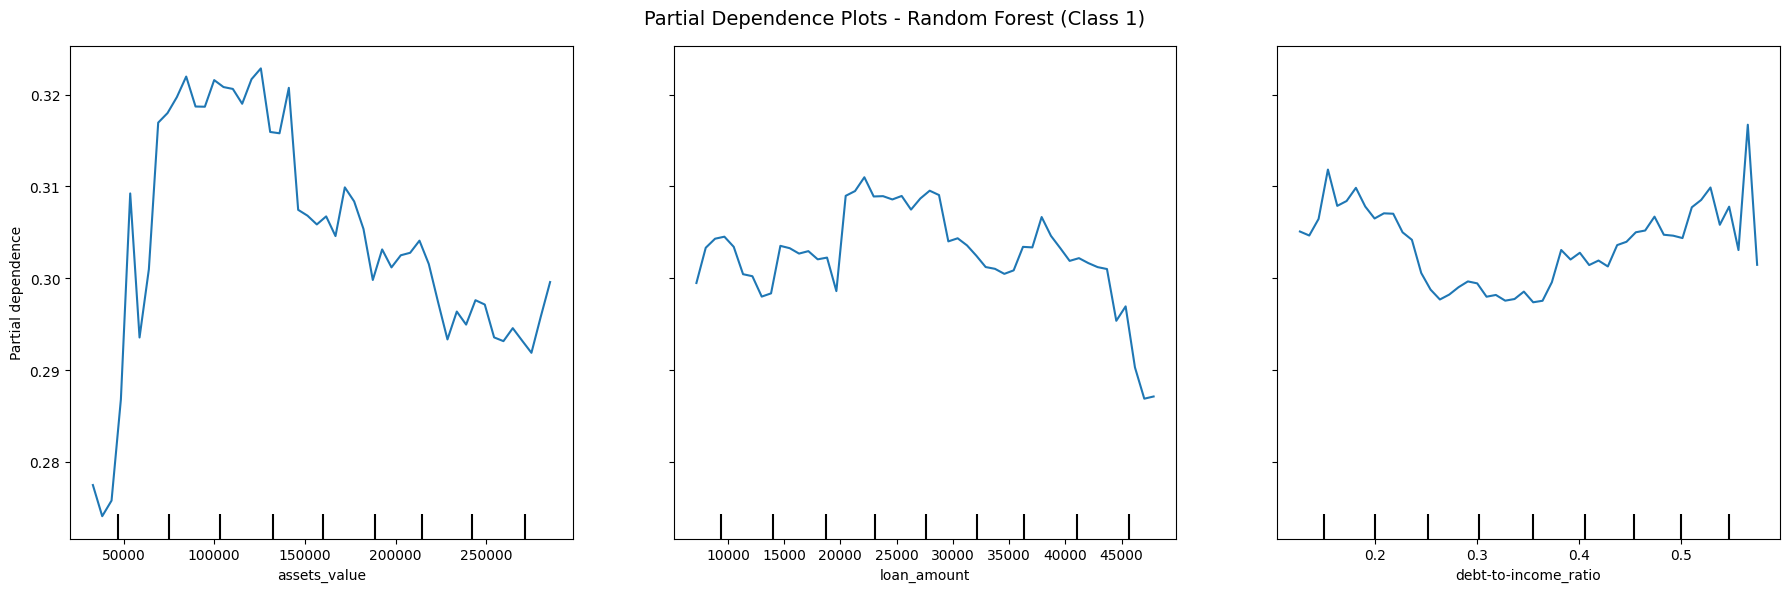

In [51]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize=(18, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, X_train, top_features, ax=ax, grid_resolution=50,
    target=1  # Specify class 1 (medium risk)
)
plt.suptitle("Partial Dependence Plots - Random Forest (Class 1)", fontsize=14)
plt.tight_layout()
plt.show()

- For `assets value`, the PDP showed that as assets increased from lower levels, the probability of medium risk also rose slightly, peaking around the mid-range then tapering off. This was interesting because I originally expected higher assets lead to lower risk, but the model instead followed a non-linear pattern, maybe due to the interactions with income or loan size.

- For `loan amount`, the PDP showed a small increase in medium-risk probability at mid-level loans, followed by a drop at higher amounts. I guess this might because the model learning that borrowers with very large loans may either be high risk or low risk depending on context, so the medium-risk category is less common at the extremes.

- For `debt-to-income ratio`, the PDP indicated a U-shaped pattern, with medium risk being less likely at moderate ratios but more likely again at very high or very low ratios. This was also not I expected. I thought higher debt burden, higher risk.

### 4.2 ICE Plot

The Individual Conditional Expectation (ICE) plot extends the idea of PDP by showing how each individual observation responds to changes in a feature. Instead of only the average effect, ICE lets us see the variation across borrowers, which highlights potential interactions and heterogeneous patterns.

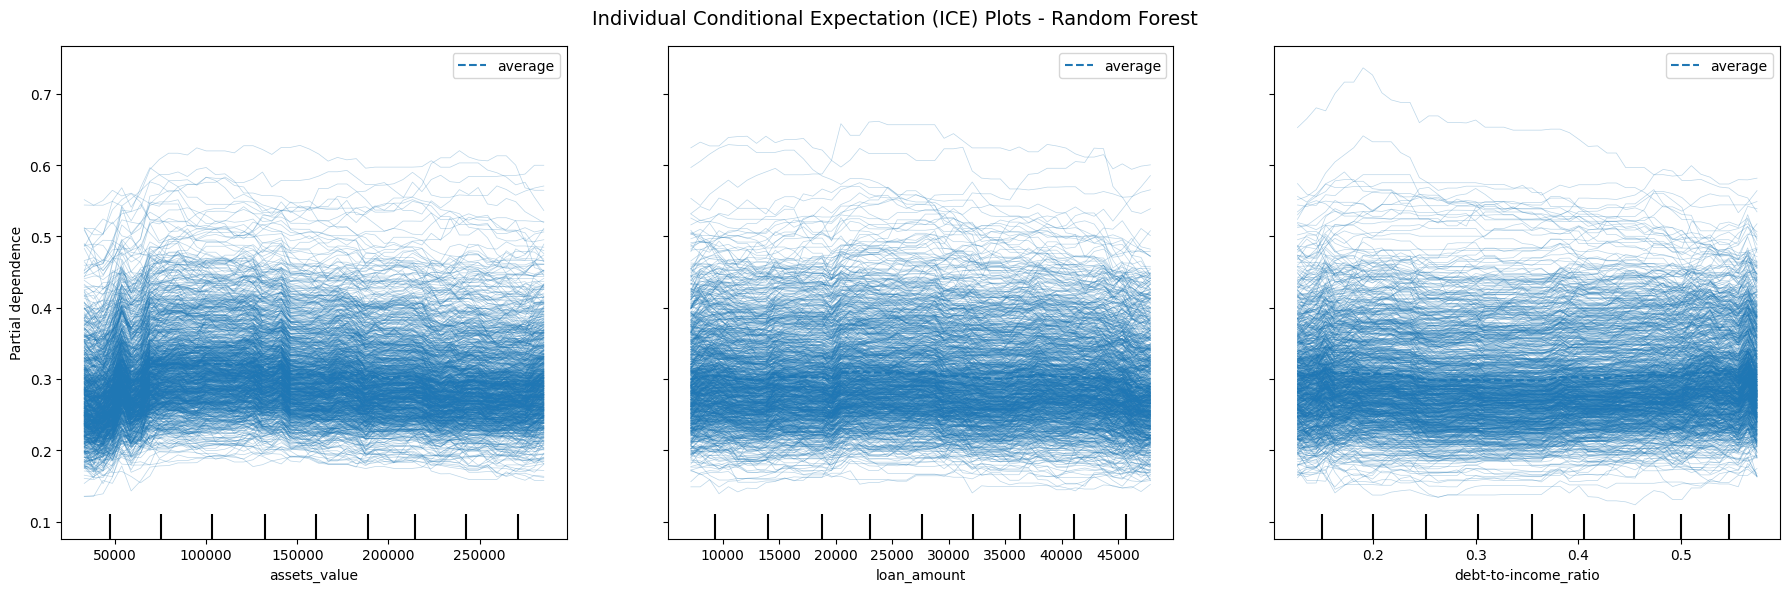

In [52]:
fig, ax = plt.subplots(figsize=(18, 6))
PartialDependenceDisplay.from_estimator(
    rf_model, X_train, top_features,
    ax=ax, grid_resolution=50, kind="both",
    target=1  # Specify which class
)
plt.suptitle("Individual Conditional Expectation (ICE) Plots - Random Forest", fontsize=14)
plt.tight_layout()
plt.show()

- For `assets value`, I saw that while the average effect in the ICE plot was fairly flat, individual lines varied a lot. Some borrowers’ probabilities of medium risk increased with higher assets, while others stayed constant.

- For `loan amount`, many borrowers followed the average trend of a slight bump in medium risk at mid-level loans, although some deviated, with risk either steadily increasing or staying unchanged. This suggested that the relationship between loan amount and medium risk varies across different borrowers.

- The `debt-to-income ratio` ICE plot also revealed variation across individuals. Different from PDP, the ICE curves showed that not all borrowers follow U-shape pattern. For some, higher ratios clearly increased medium risk probability, while for others, the effect was weaker or even flat. This heterogeneity makes sense to me, because debt burden interacts with assets and income levels.

### 4.3 ALE PLot

The Accumulated Local Effects (ALE) plots show how a feature influences predictions within the regions of the data where values actually occur. Unlike PDP, which averages across the whole dataset, ALE avoids extrapolating into unrealistic combinations and instead captures local, more reliable effects.

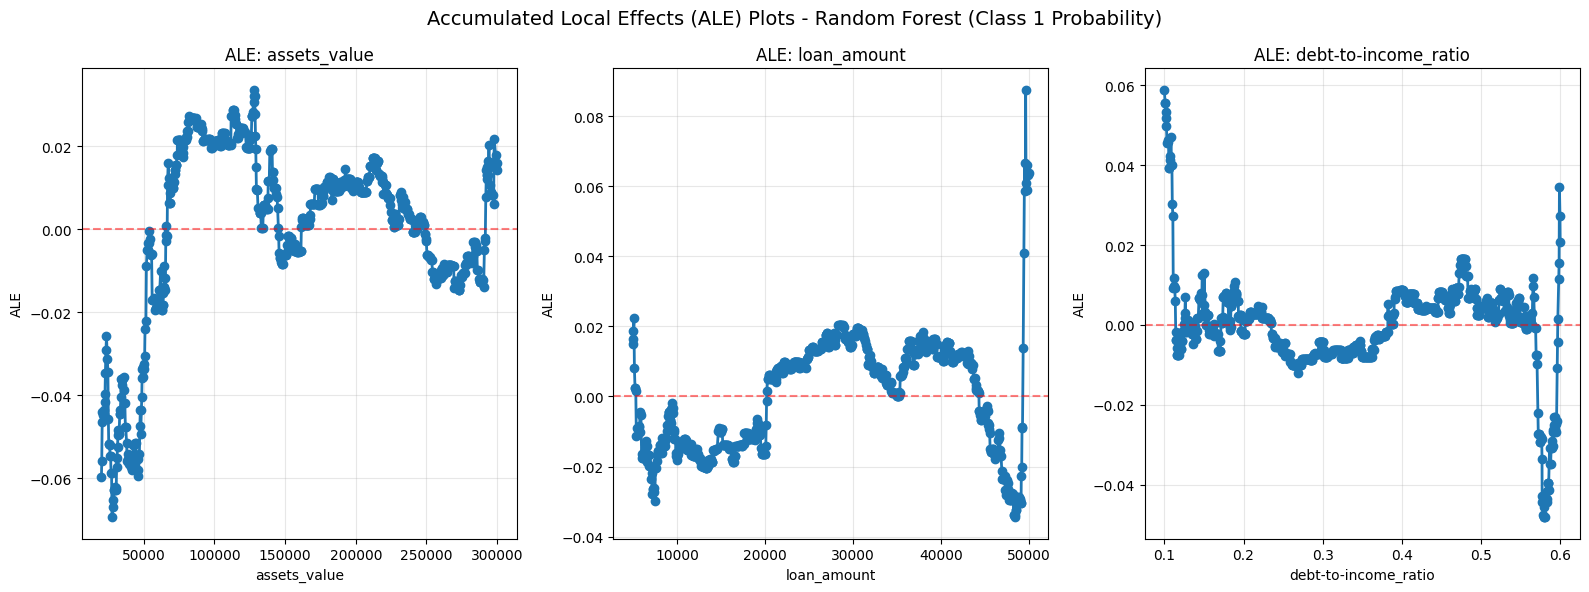

In [53]:
from alibi.explainers import ALE

# Wrapper for probability predictions
def predict_proba_class1(X):
    return rf_model.predict_proba(X)[:, 1]

ale_explainer = ALE(predict_proba_class1, feature_names=X_train.columns.tolist())

fig, axes = plt.subplots(1, len(top_features), figsize=(16, 6))

for i, feature in enumerate(top_features):
    feature_idx = X_train.columns.get_loc(feature)
    ale_exp = ale_explainer.explain(X_train.values, features=[feature_idx])

    axes[i].plot(ale_exp.feature_values[0], ale_exp.ale_values[0], marker='o', linewidth=2)
    axes[i].axhline(y=0, color='red', linestyle='--', alpha=0.5)
    axes[i].set_title(f'ALE: {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('ALE')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Accumulated Local Effects (ALE) Plots - Random Forest (Class 1 Probability)', fontsize=14)
plt.tight_layout()
plt.show()

- For `assets value`, the ALE plot showed that at very low levels of assets, the probability of being medium risk decreased. As assets rose into mid-ranges, the effect turned positive, suggesting higher medium-risk probability, before flattening out at very high values.

- For `loan amount`, the ALE curve indicated negative effects at low and high loan values, with a positive bump in the middle ranges. This means medium-risk borrowers are more likely to appear at moderate loan amounts, while very small or very large loans tend to push the model toward other risk classes.

- For `debt-to-income ratio`, I noticed the ALE was mostly flat in the middle, but spiked at the extremes. Very low and very high ratios were associated with higher probabilities of medium risk. This supported my earlier observation from PDP and ICE that unusual borrower profiles (either taking on very little debt or being heavily leveraged) are more likely to be classified as medium risk.

Going back to my earlier correlation analysis, I now see why the effects in the PDP, ICE, and ALE plots often appeared modest. Since no single feature was strongly correlated with the target, the model couldn’t base its predictions on one variable alone. Instead, it had to combine multiple features together in complex, nonlinear ways.

That’s why methods like ALE and ICE became valuable: ALE shows the effect of a feature in the context of realistic data values, while ICE shows how different individuals can respond differently to the same feature. Together, they help uncover the interactions and hidden patterns that a simple average trend (like PDP) might miss.